In [94]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image


In [95]:
class CustomImageDataset(Dataset):
    def __init__(self, base_dir, subfolders, transform=None):
        self.base_dir = base_dir
        self.subfolders = subfolders
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder)
            label = subfolder

            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)
        
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label


In [96]:
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Define base directory and subfolders for different classes
base_dir = r'DIAT-uSAT_dataset'
subfolders = [
    r"3_long_blade_rotor", 
    r"3_short_blade_rotor", 
    r"Bird", 
    r"Bird+mini-helicopter", 
    r"drone", 
    r"rc_plane", 
]

# Hyperparameters
input_size = 3 * 224 * 224  # 3 channels, image size 224x224
hidden_size = 256
num_layers = 3
num_classes = len(subfolders)
learning_rate = 0.001
batch_size = 32
num_epochs = 10
best_val_accuracy = 0
best_model_path = 'best_model_CustomVGGWithAttentionattention.pt'


In [97]:
# Create the dataset and dataloaders
dataset = CustomImageDataset(base_dir, subfolders, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [98]:
class LSTMImageClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMImageClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer (input_size will be the flattened size of image)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Initialize hidden and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Take the output of the last time step
        out = out[:, -1, :]
        
        # Fully connected layer
        out = self.fc(out)
        return out


In [99]:
# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = LSTMImageClassifier(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [102]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Flatten the image from (batch_size, channels, height, width) to (batch_size, 1, input_size)
        imgs = imgs.view(imgs.size(0), 1, -1)
        
        # Forward pass
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validation after each epoch
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs = imgs.view(imgs.size(0), 1, -1)  # Flatten for validation
            
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    print(f'Validation Accuracy after Epoch {epoch+1}: {val_accuracy:.2f}%')

    # Save the best model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)


In [81]:
# Load the best saved model
model = LSTMImageClassifier(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set model to evaluation mode


C:\Users\Shravya H Jain\AppData\Local\Temp\ipykernel_35804\2189516006.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


LSTMImageClassifier(
  (lstm): LSTM(150528, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [82]:
def test_model(test_loader, model):
    model.eval()  # Set model to evaluation mode
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            # Flatten the image from (batch_size, channels, height, width) to (batch_size, 1, input_size)
            imgs = imgs.view(imgs.size(0), 1, -1)
            
            # Forward pass through the model
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * test_correct / test_total
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    
    return all_preds, all_labels


In [83]:
# Assuming you have a test_loader similar to train_loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Test the model
all_preds, all_labels = test_model(test_loader, model)


Test Accuracy: 33.74%


                      precision    recall  f1-score   support

  3_long_blade_rotor       0.00      0.00      0.00        72
 3_short_blade_rotor       0.00      0.00      0.00        85
                Bird       0.33      0.97      0.49        76
Bird+mini-helicopter       0.00      0.00      0.00        78
               drone       0.45      0.72      0.55        85
            rc_plane       0.23      0.32      0.27        90

            accuracy                           0.34       486
           macro avg       0.17      0.34      0.22       486
        weighted avg       0.17      0.34      0.22       486



c:\Users\Shravya H Jain\Desktop\ML+AI\Micro-Doppler-Based-Target-Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shravya H Jain\Desktop\ML+AI\Micro-Doppler-Based-Target-Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shravya H Jain\Desktop\ML+AI\Micro-Doppler-Based-Target-Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predi

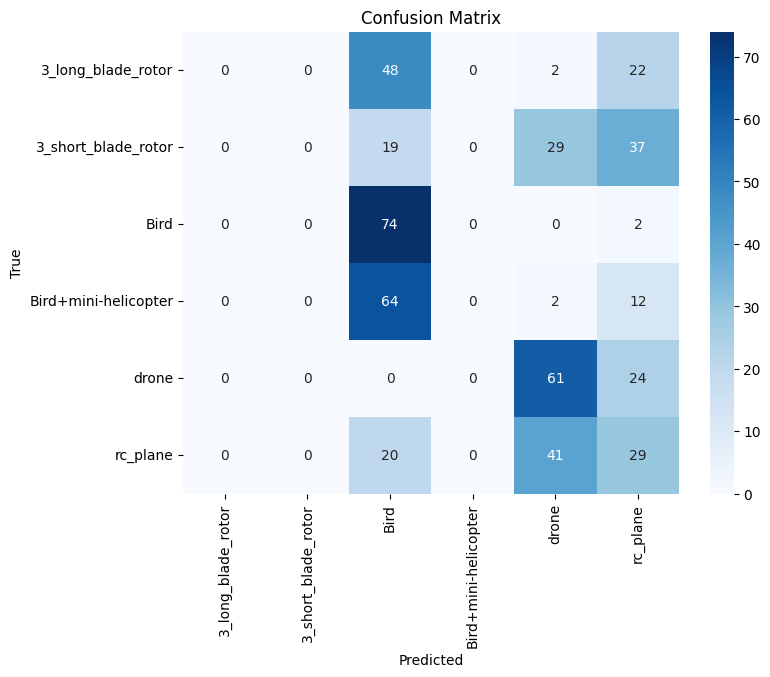

In [85]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Print classification report
print(classification_report(all_labels, all_preds, target_names=subfolders))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=subfolders, yticklabels=subfolders)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [92]:
def test_model(test_loader, model):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient tracking
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            # Get the batch size
            batch_size = imgs.size(0)

            # Flatten the images to 2D (batch_size, input_size)
            imgs = imgs.view(batch_size, -1)  # Reshape to (batch_size, input_size)

            # Reshape for LSTM input: (batch_size, seq_length, input_size)
            imgs = imgs.unsqueeze(1)  # Add sequence dimension, resulting in (batch_size, seq_length=1, input_size)

            # Forward pass through the model
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)

            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds) * 100
    print(f'Test Accuracy: {accuracy:.2f}%')
    


In [93]:
test_model(test_loader, model)

Test Accuracy: 33.95%
